In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2
## Load HINT Raw Data
**Source: http://hint.yulab.org/download/HomoSapiens/binary/hq/ ; http://hint.yulab.org/download/HomoSapiens/cocomp/hq/**  
Downloaded: November 16, 2021  
Last updated: August 2021.   
The two binary interactomes for High-Quality (HQ) and Co-Complex (CC) interactions were downloaded and merged into a single interactome for HINT.     
Citation: Das J and Yu H. HINT: High-quality protein interactomes and their applications in understanding human disease. BMC Systems Biology, 2012 Jul 30;6(1):92.

In [3]:
input_raw_bi_v2 = pd.read_csv(wd+'Network_Data_Raw/HINT/HomoSapiens_binary_hq.txt',sep='\t')
input_raw_co_v2 = pd.read_csv(wd+'Network_Data_Raw/HINT/HomoSapiens_cocomp_hq.txt',sep='\t')
print("Binary HQ:", len(input_raw_bi_v2))
print("Co-complex:", len(input_raw_co_v2))

Binary HQ: 126960
Co-complex: 188605


In [4]:
input_raw_v2 = pd.concat([input_raw_bi_v2, input_raw_co_v2])
print('Concatenated list of edges:', input_raw_v2.shape)
input_raw_v2 = input_raw_v2.drop_duplicates()
print('After duplicate edges removed:', input_raw_v2.shape)

Concatenated list of edges: (315565, 9)
After duplicate edges removed: (315104, 9)


In [5]:
# Use UniProtID labels to annotate interactions
genes_v2 = set(input_raw_v2['Uniprot_A']).union(set(input_raw_v2['Uniprot_B']))

## Convert Genes from UniProt Accession ID to gene symbols

In [6]:
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2)

17933 Valid Query Genes
0 Invalid Query Genes


In [7]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)
print(len(match_list_v2), 'Matched query results')

100%|██████████| 18/18 [00:13<00:00,  1.30it/s]

18207 Matched query results
Batch query complete: 13.93 seconds
18207 Matched query results


In [8]:
match_list_v2 = pd.DataFrame.from_dict(match_list_v2)
missing_uni = match_list_v2.loc[match_list_v2.notfound==True, ("query")].tolist()

In [9]:
uniprot_mapping, _ = gct.query_uniprot(missing_uni, source_fmt="ACC+ID", target_fmt=["GENENAME", "P_ENTREZGENEID"],
                                   output_fmt='tab', return_as_dict=False)

final_mapping_v2 = match_list_v2.loc[~match_list_v2["query"].isin(uniprot_mapping["query"].tolist()), 
                                     ("query", "symbol","_score", "entrezgene")]
final_mapping_v2 = pd.concat([final_mapping_v2, uniprot_mapping])

In [10]:
check_names_v2 = final_mapping_v2.symbol.values
mapped_v2, unmapped_v2 = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              check_names_v2, return_as_dict=False)

In [11]:
final_mapping_v2 = final_mapping_v2.merge(mapped_v2,left_on=["symbol"], right_on=["Query"], how='outer', 
                                    suffixes=["", "-y"]).loc[:, ("query", "Approved symbol", "NCBI Gene ID", "_score")]
final_mapping_v2.columns = ["query", "symbol", "entrezgene", "_score"]

In [12]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(final_mapping_v2, valid_genes_v2)

Number of genes with multiple matches: 288
Number of unmatched genes: 812
Number of fully matched genes: 17040
Number of partially matched genes: 893


## Construct Converted Network

In [13]:
edgelist_v2 = input_raw_v2.loc[:, ['Uniprot_A', 'Uniprot_B']]

In [14]:
# Convert edge list
edgelist_symbol_v2 = gct.convert_edgelist(edgelist_v2, query_to_symbol_v2)

name_map = {'Uniprot_A':"symbol_n1", 'Uniprot_B': "symbol_n2"}
edgelist_symbol_v2.rename(columns=name_map, inplace=True)

In [15]:
# Filter edge list
edgelist_filt_v2 = gct.filter_converted_edgelist(edgelist_symbol_v2)

315104 input edges
6228 self-edges removed
3580 edges with un-mapped genes removed
18044 duplicate edges removed
Edge list filtered: 0.14 seconds
287252 Edges remaining


In [16]:
# Save edge list
gct.write_edgelist(edgelist_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/HINT_Symbol_2021.sif')

Edge list saved: 0.27 seconds


# Version 1
## Load HINT Raw Data
**Source: http://hint.yulab.org/batch.html**  
Downloaded: June 15, 2017  
Last update not listed, but currently on version 4 (updated early 2017).  
The two binary interactomes for High-Quality (HQ) and Co-Complex (CC) interactions were downloaded and merged into a single interactome for HINT.     
Citation: Das J and Yu H. HINT: High-quality protein interactomes and their applications in understanding human disease. BMC Systems Biology, 2012 Jul 30;6(1):92.

**Note on 2021 re-run: the number of matched genes has changed slightly due to updated/changed gene identifiers** 


In [17]:
input_raw_bi = pd.read_csv(wd+'Network_Data_Raw/HINT/HINT_v4_binary_HomoSapiens.txt',sep='\t')
input_raw_co = pd.read_csv(wd+'Network_Data_Raw/HINT/HINT_v4_complex_HomoSapiens.txt',sep='\t')
print("Binary HQ:", len(input_raw_bi))
print("Co-complex:", len(input_raw_co))

Binary HQ: 59128
Co-complex: 122571


In [18]:
input_raw = pd.concat([input_raw_bi, input_raw_co])
print('Concatenated list of edges:', input_raw.shape)
input_raw = input_raw.drop_duplicates()
print('After duplicate edges removed:', input_raw.shape)

Concatenated list of edges: (181699, 9)
After duplicate edges removed: (181375, 9)


In [19]:
# Use UniProtID labels to annotate interactions
genes = set(input_raw['Uniprot_A']).union(set(input_raw['Uniprot_B']))

## Convert Genes from UniProt Accession ID to gene symbols

In [20]:
query_string, valid_genes, invalid_genes = gct.query_constructor(genes)

15784 Valid Query Genes
0 Invalid Query Genes


In [21]:
# Set scopes (gene naming systems to search)
scopes = "uniprot"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

15974 Matched query results
Batch query complete: 12.34 seconds
15974 Matched query results


In [22]:
match_list = pd.DataFrame.from_dict(match_list)
missing_uni = match_list.loc[match_list.notfound==True, ("query")].tolist()

In [23]:
uniprot_mapping, _ = gct.query_uniprot(missing_uni, source_fmt="ACC+ID", target_fmt=["GENENAME", "P_ENTREZGENEID"],
                                   output_fmt='tab', return_as_dict=False)

final_mapping = match_list.loc[~match_list["query"].isin(uniprot_mapping["query"].tolist()), 
                                     ("query", "symbol","_score", "entrezgene")]
final_mapping = pd.concat([final_mapping, uniprot_mapping])

In [24]:
check_names = final_mapping.symbol.values
mapped, unmapped = gct.query_against_dataset("~/Data/Network_Analysis/Reference_Data/HGNC_download_2022.txt",
                              check_names, return_as_dict=False)

In [25]:
final_mapping = final_mapping.merge(mapped,left_on=["symbol"], right_on=["Query"], how='outer', 
                                    suffixes=["", "-y"]).loc[:, ("query", "Approved symbol", "NCBI Gene ID", "_score")]
final_mapping.columns = ["query", "symbol", "entrezgene", "_score"]

In [26]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(final_mapping, valid_genes)

Number of genes with multiple matches: 254
Number of unmatched genes: 451
Number of fully matched genes: 15258
Number of partially matched genes: 526


## Construct Converted Network

In [27]:
edgelist = input_raw.loc[:, ['Uniprot_A', 'Uniprot_B']]

In [28]:
# Convert edge list
edgelist_symbol = gct.convert_edgelist(edgelist, query_to_symbol)

name_map = {'Uniprot_A':"symbol_n1", 'Uniprot_B': "symbol_n2"}
edgelist_symbol.rename(columns=name_map, inplace=True)

In [29]:
# Filter edge list
edgelist_filt = gct.filter_converted_edgelist(edgelist_symbol)

181375 input edges
4610 self-edges removed
1766 edges with un-mapped genes removed
18724 duplicate edges removed
Edge list filtered: 0.08 seconds
156275 Edges remaining


In [30]:
# Save edge list
gct.write_edgelist(edgelist_filt, wd+'Processed_Data/Network_SIFs_Symbol/HINT_Symbol_v4_2017.sif')

Edge list saved: 0.15 seconds


# Changes

No human filtering done


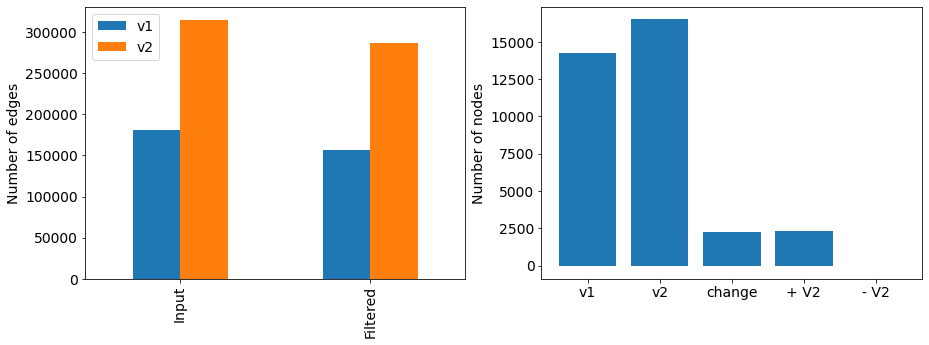

In [31]:
dit.plot_changes_to_dataset(input_raw, input_raw_v2, edgelist_filt, edgelist_filt_v2)

<AxesSubplot:>

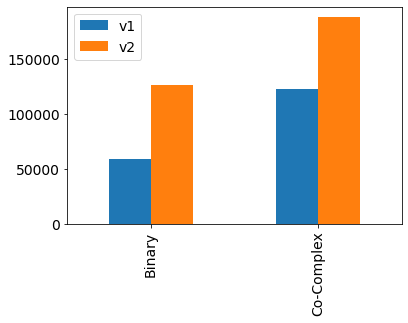

In [32]:
source_stats = pd.DataFrame({"v1": [len(input_raw_bi), len(input_raw_co)], "v2":[len(input_raw_bi_v2), len(input_raw_co_v2)]},
                           index = ["Binary", "Co-Complex"])
source_stats.plot.bar()